In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
import jiwer

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader

import transformers
from datasets import load_metric
from transformers import TrOCRProcessor, TrOCRConfig
from transformers import VisionEncoderDecoderModel
from transformers import AdamW

import os
import xml.etree.ElementTree as ET 
import rasterio
from tqdm import tqdm
import json
import pickle

In [2]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import warnings
warnings.simplefilter('ignore', UserWarning)

In [4]:
cvl_data_path = '../handwritten-text-recognition(old)/cvl-database-1-1/'
cvl_cropped_images =  cvl_data_path+'cvl-database-cropped-1-1/'
root_dir = '../handwritten-text-recognition(old)/'

PAGE = False

## Parse XML files and create the line-level labels from them 

In [5]:
def parseXML(file_path):
    with open(file_path, 'rb') as file:
            content = file.read()

    content = content.decode('utf-8', errors='replace')
    content = content.replace('encoding="ISO-8859-1"', 'encoding="utf-8"')

    # Parse the XML content
    root = ET.fromstring(content)
    namespace = {'ns': 'http://schema.primaresearch.org/PAGE/gts/pagecontent/2010-03-19'}
    lines = []

    # Find all AttrRegion elements with attrType=3 and fontType=2
    for region in root.findall('.//ns:AttrRegion[@attrType="3"][@fontType="2"]', namespace):
        # Find all child AttrRegion elements with attrType=2
        for sub_region in region.findall('.//ns:AttrRegion[@attrType="2"]', namespace):
            # Create a list to hold words for each line
            line = []

            # Find all child AttrRegion elements with attrType=1
            for word_region in sub_region.findall('.//ns:AttrRegion[@attrType="1"]', namespace):
                # Extract the text attribute value
                text = word_region.get('text')
                if text:
                    line.append(text)
            if line:
                lines.append(" ".join(line))

    return (lines, len(lines))

In [6]:
def make_split_lines(split):    
    df = {}
    for file_path in sorted(os.listdir(cvl_data_path+split+'/xml')):
        lines, num_lines = parseXML(cvl_data_path+split+'/xml/'+file_path)

        temp1 = file_path.split("_")[0]
        temp1 = [temp1]*num_lines
        temp2 = [str(i) for i in range(num_lines)]
        names = [x+'-'+y for x, y in zip(temp1, temp2)]

        df.update(zip(names, lines))

    df1 = pd.DataFrame(df.items(), columns=['file_name', 'text'])
    df1['file_name'] = df1['file_name'].apply(lambda x: x+'.tif')
    df1.to_csv(root_dir+"line_"+split+'.csv', index=False)
    

def make_split_page(split):
    df = {}
    for file_path in sorted(os.listdir(cvl_data_path+split+'/xml')):
        lines, num_lines = parseXML(cvl_data_path+split+'/xml/'+file_path)

        temp1 = file_path.split("_")[0]
        file_name = temp1 + '-cropped.tif'
        label = " ".join(lines)
        df.update({file_name:label})
        
    df1 = pd.DataFrame(df.items(), columns=['file_name', 'text'])
    df1.to_csv(root_dir+"page_"+split+'.csv', index=False)

In [7]:
# make_split_lines('trainset')
# make_split_lines('testset')

# make_split_page('trainset')
# make_split_page('testset')

## Model training

In [5]:
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")

In [6]:
trainset_line = pd.read_csv(root_dir+'lines_trainset.csv')
testset_line = pd.read_csv(root_dir+'lines_testset.csv')

trainset_page = pd.read_csv(root_dir+'page_trainset.csv')
testset_page = pd.read_csv(root_dir+'page_testset.csv')
# some XML files are faulty and do not contain label information. XML parses returns NaN. These NaN values are replaced by the following text
testset_page.fillna('Text not available', inplace=True)

90 47 64.26984126984127


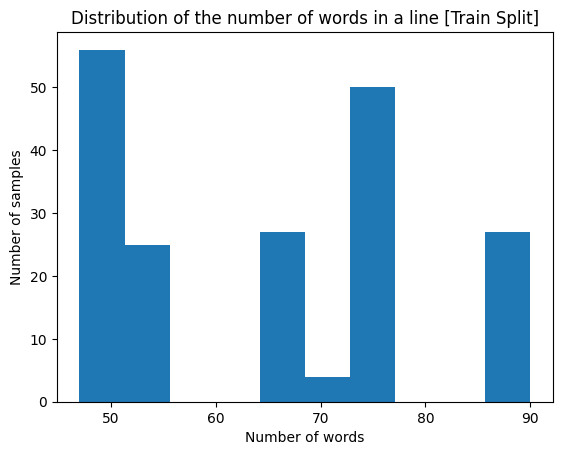

In [7]:
# visualizing the length of labels to determine the max_seq_length 

def dist(seq, page=False, split=None):
    text_len = seq.apply(lambda x: len(x.split(" ")))
    print(text_len.max(), text_len.min(), text_len.mean())
    plt.hist(text_len)
    if page == False:
        plt.title("Distribution of the number of words in a line [{} Split]".format(split))
    else:
        plt.title("Distribution of the number of words in a full text [{} Split]".format(split))
    plt.xlabel("Number of words")
    plt.ylabel("Number of samples")
    plt.show()

# Uncomment only one at a time to produce that particular plot 
dist(trainset_page['text'], split='Train', page=PAGE)
# dist(testset_page['text'], split='Test', page=True)
# dist(trainset_line['text'], split='Train', page=False)
# dist(testset_line['text'], split='Test', page=False)

In [8]:
class CVLDataset(Dataset):
    def __init__(self, processor, split=None, page=False):
        self.processor = processor
        
        if page:
            self.img_dir = cvl_cropped_images
            self.max_target_length = 100
            if split.lower() == 'train':
                self.df = pd.read_csv(root_dir+'page_trainset.csv')
            elif split.lower() == 'test':
                self.df = pd.read_csv(root_dir+'page_testset.csv')
                # some XML files are faulty and do not contain label information. XML parses returns NaN. These NaN values are replaced by the following text
                self.df.fillna('Text not available', inplace=True)
        else:
            self.img_dir = cvl_data_path+split+'set/lines/'
            self.max_target_length = 25
            if split.lower() == 'train':
                self.df = pd.read_csv(root_dir+'lines_trainset.csv')
            elif split.lower() == 'test':
                self.df = pd.read_csv(root_dir+'lines_testset.csv')
                
        self.page = page

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx, return_orig=False):
        file_name, text = self.df.iloc[idx, :]
        if self.page == False:
            folder = file_name.split("-")[0]
            image = rasterio.open(self.img_dir+folder+'/'+file_name)
            image = image.read()
        else:
            image = rasterio.open(self.img_dir+file_name)
            image = image.read()
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, 
                                          padding="max_length", 
                                          max_length=self.max_target_length,
                                          truncation=True,
                                         ).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]
        
        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        
        if return_orig:
            return image, text, encoding
        else:
            return encoding

In [9]:
train_data = CVLDataset(split='train', page=PAGE, processor=processor)
test_data = CVLDataset(split='test', page=PAGE, processor=processor)
print("Number of training examples:", len(train_data))
print("Number of testing examples:", len(test_data))

train_loader = DataLoader(train_data, batch_size=16, shuffle=False, pin_memory=True, num_workers=18)
test_loader = DataLoader(test_data, batch_size=16, shuffle=True, pin_memory=True, num_workers=18)

Number of training examples: 1612
Number of testing examples: 11828


of art You have thrown it all away You are
torch.Size([3, 384, 384]) torch.Size([25])


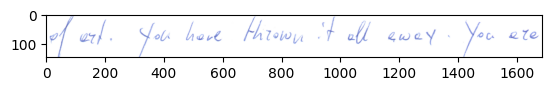

In [10]:
# visualizing a random sample; sanity check 
image, text, encoding = train_data.__getitem__(111, return_orig=True)
plt.imshow(image.transpose(1,2,0))
print(text)

print(encoding['pixel_values'].shape, encoding['labels'].shape)

In [11]:
cer_metric = load_metric("cer")

def compute_metrics(pred_ids, label_ids):
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)
    wer = jiwer.wer(label_str, pred_str)
    
    return cer, wer

/tmp/ipykernel_2042521/1836669260.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer_metric = load_metric("cer")
/home/swapnanil_mukherjee/data_distillation/lib/python3.8/site-packages/datasets/load.py:759: FutureWarning: The repository for cer contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/cer/cer.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [12]:
scaler = torch.cuda.amp.GradScaler()

In [13]:
def train(model, dataloader, optimizer, scheduler=None):
    model.train()
    
    running_loss = 0.0
    nb_tr_steps = 0
    
    for batch in tqdm(dataloader):
        # move pixel values to the GPU
        for k,v in batch.items():
            batch[k] = v.to(device, non_blocking=True)

        with torch.autocast(dtype=torch.float16, device_type=device):
            outputs = model(**batch)
            loss = outputs.loss 
        
#         loss.backward()
        scaler.scale(loss).backward()
#         optimizer.step()
        scaler.step(optimizer)
        optimizer.zero_grad()
        scaler.update()
        
        if scheduler != None:
            scheduler.step()
        
        running_loss += loss
        nb_tr_steps += 1
    
    return model, running_loss/nb_tr_steps


def evaluate(model, dataloader):
    model.eval()
    
    running_loss = 0.0
    nb_tr_steps = 0.0
    tmp_eval_cer, tmp_eval_wer = 0.0, 0.0
    output_ids = []
    
    for batch in tqdm(dataloader):
        # move pixel values to the GPU
        for k,v in batch.items():
            batch[k] = v.to(device, non_blocking=True)
        
        with torch.autocast(dtype=torch.float16, device_type=device):
            with torch.no_grad():
                outputs = model(**batch)
            loss = outputs.loss
        
        b_output_ids = model.generate(batch["pixel_values"].to(device))
        output_ids.extend(b_output_ids)
        cer, wer = compute_metrics(pred_ids=b_output_ids, label_ids=batch["labels"])
        
        running_loss += loss
        tmp_eval_cer += cer
        tmp_eval_wer += wer
        nb_tr_steps += 1
    
    return running_loss/nb_tr_steps, tmp_eval_cer/nb_tr_steps, tmp_eval_wer/nb_tr_steps, output_ids


In [14]:
device = 'cuda'

def get_model(path, train_page=False):
    model = VisionEncoderDecoderModel.from_pretrained(path)
    model.to(device)
    # set special tokens used for creating the decoder_input_ids from the labels
    model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
    model.config.pad_token_id = processor.tokenizer.pad_token_id
    model.config.vocab_size = model.config.decoder.vocab_size

    # set beam search parameters
    model.config.eos_token_id = processor.tokenizer.sep_token_id
    if train_page:
        max_length = 100
    else:
        max_length = 25
    model.config.max_length = max_length
    model.config.early_stopping = True
    model.config.no_repeat_ngram_size = 3
    model.config.length_penalty = 2.0
    model.config.num_beams = 5
    
    return model 

def get_optimizer(model, lr):
    optimizer = AdamW(model.parameters(), lr=lr)
    
    return optimizer

In [17]:
def run(model_path, epochs):

    model = get_model(model_path, train_page=True)
    optimizer = get_optimizer(model, lr=1e-6)

    tr_loss_set, val_loss_set = [], []
    cer_set, wer_set = [], []
    best_cer, best_wer = 100, 100

    for epoch in range(epochs):
        print("Epoch {}/{}".format(epoch, epochs), end='\t')
        model, tr_loss = train(model, test_loader, optimizer)
        val_loss, cer, wer, str_outputs = evaluate(model, train_loader)

        tr_loss_set.append(tr_loss.item())
        val_loss_set.append(val_loss.item())
        cer_set.append(cer)
        wer_set.append(wer)

        print("Train loss:{}".format(tr_loss), end='\t')
        print("Val loss:{}".format(val_loss), end='\t')
        print("CER:{}".format(cer), end='\t')
        print("WER:{}".format(cer))
        print("==============================================================================")
        
        if cer < best_cer and wer < best_wer:
#             if not PAGE:
#                 torch.save(model.state_dict(), root_dir+'checkpoints/'+model_path.split('/')[1]+'_finetuned_line-level.pth')
#             else:
#                 torch.save(model.state_dict(), root_dir+'checkpoints/'+model_path.split('/')[1]+'_finetuned_page-level.pth')
            best_cer = cer
            best_wer = wer 
            best_outputs = str_outputs
        if cer < best_wer:
            best_cer = cer
        if wer < best_wer:
            best_wer = wer
    
    output_str = processor.tokenizer.batch_decode(best_outputs, skip_special_tokens=True)
#     print(output_str)
    
    with open(root_dir+'recognized_text.pickle', 'wb') as file:
        pickle.dump(output_str, file, protocol=pickle.HIGHEST_PROTOCOL)
        
    return tr_loss_set, val_loss_set, cer_set, wer_set
    
epochs = 10
tr_losses, val_losses, cer_scores, wer_scores = [],[],[],[]
model_paths = ['microsoft/trocr-base-handwritten']    
for model_path in model_paths:
    tr_loss_set, val_loss_set, cer_set, wer_set = run(model_path, epochs)
    
    tr_losses.append(tr_loss_set)
    val_losses.append(val_loss_set)
    cer_scores.append(cer_set)
    wer_scores.append(wer_set)

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 0/10	

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [06:07<00:00,  3.64s/it]


Train loss:0.9634358286857605	Val loss:0.4429348111152649	CER:0.055740084771124604	WER:0.055740084771124604
Epoch 1/10	

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [06:11<00:00,  3.67s/it]


Train loss:0.16925360262393951	Val loss:0.38827309012413025	CER:0.04963653299151103	WER:0.04963653299151103
Epoch 2/10	

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [06:11<00:00,  3.68s/it]


Train loss:0.10817432403564453	Val loss:0.3735075891017914	CER:0.04902131662852849	WER:0.04902131662852849
Epoch 3/10	

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [06:13<00:00,  3.69s/it]


Train loss:0.07908400893211365	Val loss:0.37523457407951355	CER:0.05184733276357359	WER:0.05184733276357359
Epoch 4/10	

  0%|                                                                                                                                                                                      | 0/740 [00:00<?, ?it/s]ERROR 1: MissingRequired:TIFF directory is missing required "ImageLength" field
ERROR 1: MissingRequired:TIFF directory is missing required "ImageLength" field
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [06:13<00:00,  3.70s/it]


Train loss:0.06048237532377243	Val loss:0.36619341373443604	CER:0.05113438872813703	WER:0.05113438872813703
Epoch 5/10	

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [06:18<00:00,  3.74s/it]


Train loss:0.04815161973237991	Val loss:0.37775102257728577	CER:0.052719004820934896	WER:0.052719004820934896
Epoch 6/10	

 34%|██████████████████████████████████████████████████████████▎                                                                                                                 | 251/740 [01:25<02:33,  3.18it/s]ERROR 1: MissingRequired:TIFF directory is missing required "ImageLength" field
ERROR 1: MissingRequired:TIFF directory is missing required "ImageLength" field
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [06:24<00:00,  3.80s/it]


Train loss:0.039108067750930786	Val loss:0.3819452226161957	CER:0.05694909673034913	WER:0.05694909673034913
Epoch 7/10	

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [06:23<00:00,  3.80s/it]


Train loss:0.032452162355184555	Val loss:0.38144004344940186	CER:0.05985400501839169	WER:0.05985400501839169
Epoch 8/10	

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [06:21<00:00,  3.77s/it]


Train loss:0.02572043240070343	Val loss:0.391866534948349	CER:0.06698622739855054	WER:0.06698622739855054
Epoch 9/10	

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [06:31<00:00,  3.88s/it]


Train loss:0.021260829642415047	Val loss:0.3937839865684509	CER:0.06612527957356909	WER:0.06612527957356909


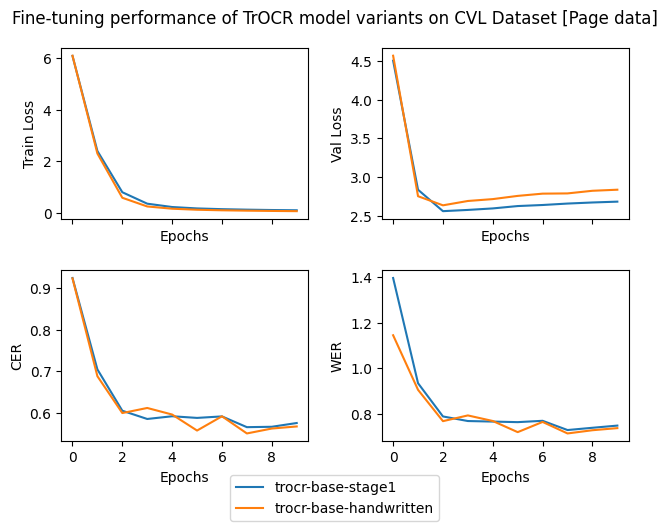

In [17]:
# for this piece of code to work correctly, the number of model_paths used in the last cell must be the same as the number of plot() calls made below for each metric. Each metric 
# list contains the metrics recorded for all the variants (model_paths) in a sequential manner. Hence, can be accessed by index.

fig, axs = plt.subplots(2,2, sharex=True, constrained_layout=True)
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=0.9, wspace=0.3, hspace=0.3)

axs[0, 0].plot(list(range(epochs)), tr_losses[0], label=model_paths[0].split('/')[1])
axs[0, 0].plot(list(range(epochs)), tr_losses[1], label=model_paths[1].split('/')[1])
axs[0, 0].set_ylabel("Train Loss")
axs[0, 0].set_xlabel("Epochs")

axs[0, 1].plot(list(range(epochs)), val_losses[0], label=model_paths[0].split('/')[1])
axs[0, 1].plot(list(range(epochs)), val_losses[1], label=model_paths[1].split('/')[1])
axs[0, 1].set_ylabel("Val Loss")
axs[0, 1].set_xlabel("Epochs")

axs[1, 0].plot(list(range(epochs)), cer_scores[0], label=model_paths[0].split('/')[1])
axs[1, 0].plot(list(range(epochs)), cer_scores[1], label=model_paths[1].split('/')[1])
axs[1, 0].set_ylabel("CER")
axs[1, 0].set_xlabel("Epochs")

axs[1, 1].plot(list(range(epochs)), wer_scores[0], label=model_paths[0].split('/')[1])
axs[1, 1].plot(list(range(epochs)), wer_scores[1], label=model_paths[1].split('/')[1])
axs[1, 1].set_ylabel("WER")
axs[1, 1].set_xlabel("Epochs")

handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.5,-0.1), loc='lower center')
if PAGE: plt.suptitle("Fine-tuning performance of TrOCR model variants on CVL Dataset [Page data]")
else: plt.suptitle("Fine-tuning performance of TrOCR model variants on CVL Dataset [Line data]")
plt.show()

In [18]:
with open(root_dir+'recognized_text.pickle', 'rb') as file:
    best_outputs = pickle.load(file)
    
# output_str = processor.tokenizer.batch_decode(best_outputs, skip_special_tokens=True)
print(best_outputs)

# with open(root_dir+"recognized_outputs.pickle", 'wb') as f:
#     pickle.dump(output_str, f)

['Imagine a vast sheet of paper on which straight', 'Lines Triangles Squares Pentagons Hexagons and other', 'figures instead of remaining fixed in their place', 'move freely about on or in the surface but without', 'the power of rising above or sinking below it', 'very much like shadows only hard and with', 'luminous edges and you will then have a', 'pretty correct notion of my country and countrymen', 'Alas a few years ago I should have said', 'my universe but now my mind has been', 'opened to higher views of things', 'And fortune on his damned quarrel smiling', "Show'd like a rebel's whore but all's too weak", 'For brave Nomacs well he deserves that name', "Disdaining fortune with his brandish'd steel", 'Which smoked with bloody execution', "Like valour's minion carved out his passage", 'Till he faced the slave', 'Mail�fterl is an Austrian nickname for the', 'first computer working solely on transistor-', 'on the European mainland It was built in', '1955 at the Vienna University of T

# Spelling Correction and NER

### Spelling Correction

In [19]:
from transformers import pipeline

fix_spelling = pipeline("text2text-generation", model="oliverguhr/spelling-correction-english-base")

corrected_outputs = fix_spelling(best_outputs, max_length=20)
corrected_outputs = [x['generated_text'] for x in corrected_outputs]
print(corrected_outputs)

['Imagine a vast sheet of paper on which straight.', 'Lines, Triangles, Squares, Pentagons, Hexagons and other.', 'Figures instead of remaining fixed in their place.', 'Move freely about on or in the surface but without.', 'The power of rising above or sinking below it.', 'Very much like shadows, only hard and with.', 'Luminous edges and you will then have a.', 'Pretty correct notion of my country and countrymen.', 'As a few years ago, I should have said.', 'My universe, but now my mind, has been.', 'opened to higher views of things.', 'And fortune on his damned quarrel smiling.', "Show'd like a rebel's whore, but all's too weak.", 'For brave Nomacs, well he deserves that name.', 'Disdaining fortune with his brandished steel.', 'Which smoked with bloody execution.', "Like valour's minions, carved out his passage.", 'Till he faced the slave.', 'Mail�fterl is an Austrian nickname for the .', 'First computer working solely on transistor-1.', 'On the European mainland, it was built in 1887

In [20]:
corrected_cer = cer_metric.compute(predictions=corrected_outputs, references=trainset_line['text'].tolist())
corrected_wer = jiwer.wer(trainset_line['text'].tolist(), corrected_outputs)

print(corrected_cer, corrected_wer)
'''
The CER and WER increases after spelling correction. 
This could be due to the fact that the spelling correction model is trained in english and there are many samples in
the test set which are in German. This needs to be ascertained.  The fact that CER doesn't increase a lot more is because the spell correction model replaces a word with another actual word
The CER remains high but the WER goes down
'''

0.10582752692064067 0.3166213879970363


"\nThe CER and WER increases after spelling correction. \nThis could be due to the fact that the spelling correction model is trained in english and there are many samples in\nthe test set which are in German. This needs to be ascertained.  The fact that CER doesn't increase a lot more is because the spell correction model replaces a word with another actual word\nThe CER remains high but the WER goes down\n"

## NER with spaCy

In [34]:
import spacy

# Load pre-trained SpaCy model
nlp = spacy.load("en_core_web_md") # because some texts are in German, a German language model may be more appropriate for those samples 

'''
The en_core_web_md model in spaCy recognizes the same set of entity types as the en_core_web_trf model, derived from the OntoNotes 5 dataset. 
Here are the entity types that en_core_web_md recognizes:

PERSON: People, including fictional.
NORP: Nationalities or religious or political groups.
FAC: Buildings, airports, highways, bridges, etc.
ORG: Companies, agencies, institutions, etc.
GPE: Countries, cities, states.
LOC: Non-GPE locations, mountain ranges, bodies of water.
PRODUCT: Objects, vehicles, foods, etc. (not services).
EVENT: Named hurricanes, battles, wars, sports events, etc.
WORK_OF_ART: Titles of books, songs, paintings, etc.
LAW: Named documents made into laws.
LANGUAGE: Any named language.
DATE: Absolute or relative dates or periods.
TIME: Times smaller than a day.
PERCENT: Percentage, including “%”.
MONEY: Monetary values, including unit.
QUANTITY: Measurements, as of weight or distance.
ORDINAL: “First”, “second”, etc.
CARDINAL: Numerals that do not fall under another type.
'''

# Define a mapping from fine-grained classification to broader categories
entity_mapping = {
    "PERSON": "PERSON",
    "NORP": "ORGANIZATION",
    "FAC": "LOCATION",
    "ORG": "ORGANIZATION",
    "GPE": "LOCATION",
    "LOC": "LOCATION",
    "PRODUCT": "QUANTITY",
    "EVENT": "DATE",
    "WORK_OF_ART": "MISC",
    "LAW": "MISC",
    "LANGUAGE": "MISC",
    "DATE": "DATE",
    "TIME": "TIME",
    "PERCENT": "QUANTITY",
    "MONEY": "MONEY",
    "QUANTITY": "QUANTITY",
    "ORDINAL": "QUANTITY",
    "CARDINAL": "QUANTITY"
}

docs = list(nlp.pipe(corrected_outputs))

# Function to extract entities from SpaCy docs; if reduced=True, a multiple fine entities are grouped together in a larger group as defined above 
def extract_entities(docs, reduced=False):
    results = []
    for doc in docs:
        entities = []
        for ent in doc.ents:
            if reduced and ent.label_ in entity_mapping:
                entities.append({
                    "text": ent.text,
                    "label": entity_mapping[ent.label_] 
                })
            else:
                entities.append({
                    "text": ent.text,
                    "label": ent.label_
                })
        results.append(entities)
    return results


# Extract entities from the batch of documents
entities_list = extract_entities(docs)

# Print the results
for text, entities in zip(corrected_outputs, entities_list):
    print(f"Text: {text}")
    for entity in entities:
        print(f" - Entity: {entity['text']} | Type: {entity['label']}")
    print()

Text: Imagine a vast sheet of paper on which straight.

Text: Lines, Triangles, Squares, Pentagons, Hexagons and other.
 - Entity: Pentagons | Type: PRODUCT
 - Entity: Hexagons | Type: PRODUCT

Text: Figures instead of remaining fixed in their place.

Text: Move freely about on or in the surface but without.

Text: The power of rising above or sinking below it.

Text: Very much like shadows, only hard and with.

Text: Luminous edges and you will then have a.

Text: Pretty correct notion of my country and countrymen.

Text: As a few years ago, I should have said.
 - Entity: a few years ago | Type: DATE

Text: My universe, but now my mind, has been.

Text: opened to higher views of things.

Text: And fortune on his damned quarrel smiling.

Text: Show'd like a rebel's whore, but all's too weak.

Text: For brave Nomacs, well he deserves that name.
 - Entity: Nomacs | Type: ORG

Text: Disdaining fortune with his brandished steel.
 - Entity: Disdaining | Type: PERSON

Text: Which smoked with

In [22]:
entities_list

[[],
 [{'text': 'Pentagons', 'label': 'PRODUCT'},
  {'text': 'Hexagons', 'label': 'PRODUCT'}],
 [],
 [],
 [],
 [],
 [],
 [],
 [{'text': 'a few years ago', 'label': 'DATE'}],
 [],
 [],
 [],
 [],
 [{'text': 'Nomacs', 'label': 'ORG'}],
 [{'text': 'Disdaining', 'label': 'PERSON'}],
 [],
 [],
 [],
 [{'text': 'Austrian', 'label': 'NORP'}],
 [{'text': 'First', 'label': 'ORDINAL'},
  {'text': 'transistor-1', 'label': 'DATE'}],
 [{'text': 'European', 'label': 'NORP'}, {'text': '1887', 'label': 'DATE'}],
 [{'text': '1955', 'label': 'DATE'},
  {'text': 'the Vienna University of Technology', 'label': 'ORG'},
  {'text': '1970', 'label': 'DATE'}],
 [{'text': 'Heinz Zemanek', 'label': 'PERSON'}],
 [],
 [{'text': 'American', 'label': 'NORP'}],
 [],
 [{'text': 'Wiener Mail', 'label': 'ORG'}],
 [{'text': 'Bin', 'label': 'PERSON'}],
 [{'text': 'Volltransistor-1 - Rechenautomat', 'label': 'NORP'}],
 [],
 [],
 [{'text': 'one', 'label': 'CARDINAL'}],
 [{'text': 'First', 'label': 'ORDINAL'}],
 [],
 [{'text':

## NER with Transformer models 

In [23]:
# medical-ner-proj/albert-medical-ner-proj ---> can be used for medical NER 
# Babelscape/wikineural-multilingual-ner ------> general purpose transformed-based multilingual NER model
# other transformer-based NER models predict only four types of entities based on the CoNLL dataset

'''
Categories recognized this model:

PER: Person
LOC: Location
ORG: Organization, company, etc.
MISC: Anything outside of above three categories
'''

from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("Babelscape/wikineural-multilingual-ner")
model = AutoModelForTokenClassification.from_pretrained("Babelscape/wikineural-multilingual-ner")

nlp = pipeline("ner", model=model, tokenizer=tokenizer, grouped_entities=True)
example = corrected_outputs

ner_results = nlp(example)
for text, entities in zip(corrected_outputs, ner_results):
    print(f"Text: {text}")
    for entity in entities:
        print(f" - Entity: {entity['word']} | Type: {entity['entity_group']}")
    print()

Text: Imagine a vast sheet of paper on which straight.

Text: Lines, Triangles, Squares, Pentagons, Hexagons and other.
 - Entity: Triangles | Type: LOC
 - Entity: Squares | Type: LOC
 - Entity: Pentagons | Type: LOC
 - Entity: Hexagons | Type: LOC

Text: Figures instead of remaining fixed in their place.
 - Entity: Figures | Type: MISC

Text: Move freely about on or in the surface but without.

Text: The power of rising above or sinking below it.

Text: Very much like shadows, only hard and with.
 - Entity: sh | Type: MISC

Text: Luminous edges and you will then have a.
 - Entity: Lu | Type: MISC

Text: Pretty correct notion of my country and countrymen.

Text: As a few years ago, I should have said.
 - Entity: I | Type: MISC

Text: My universe, but now my mind, has been.

Text: opened to higher views of things.

Text: And fortune on his damned quarrel smiling.

Text: Show'd like a rebel's whore, but all's too weak.
 - Entity: Show | Type: PER

Text: For brave Nomacs, well he deserves

## Creating JSON schema 

In [24]:
'''
metadata can be easily created out of this by defining some entities as meta entities such as DATE, TIME, LOCATION, ORGANIZATION. They will be recorded as separate fields,
and all other types entities will be clubbed under 'entities'. But special care needs to be taken such that multiple of these entities if detected by the model do not all get stored 
as metadata.
'''

data_schema = []

for text, entities in zip(corrected_outputs, entities_list):
    sample = {
        "text": text,
        "entities": {}
    }
    for entity in entities:
        if entity['label'] not in list(sample['entities'].keys()):
            sample['entities'][entity['label']] = []
        sample['entities'][entity['label']].append(entity['text'])
    data_schema.append(sample)

json_schema = json.dumps(data_schema, indent=4)
print(json_schema)

# with open(root_dir+"schema.json", 'w') as file:
#     file.write(json_schema)

[
    {
        "text": "Imagine a vast sheet of paper on which straight.",
        "entities": {}
    },
    {
        "text": "Lines, Triangles, Squares, Pentagons, Hexagons and other.",
        "entities": {
            "PRODUCT": [
                "Pentagons",
                "Hexagons"
            ]
        }
    },
    {
        "text": "Figures instead of remaining fixed in their place.",
        "entities": {}
    },
    {
        "text": "Move freely about on or in the surface but without.",
        "entities": {}
    },
    {
        "text": "The power of rising above or sinking below it.",
        "entities": {}
    },
    {
        "text": "Very much like shadows, only hard and with.",
        "entities": {}
    },
    {
        "text": "Luminous edges and you will then have a.",
        "entities": {}
    },
    {
        "text": "Pretty correct notion of my country and countrymen.",
        "entities": {}
    },
    {
        "text": "As a few years ago, I should have sai

## Sample testing

In [29]:
from PIL import Image
image_folder =  root_dir+'/test_images/'

images = []
for file in sorted(os.listdir(image_folder)):
    print(file)
    img = Image.open(image_folder+file)
    images.append(img)

test_handwritten_1.jpg
test_handwritten_10.jpg
test_handwritten_2.jpg
test_handwritten_3.jpg
test_handwritten_4.jpg
test_handwritten_5.jpg
test_handwritten_6.jpg
test_handwritten_7.jpg
test_handwritten_8.jpg
test_handwritten_9.jpg


In [30]:
temp = images.pop(1)
images.append(temp)

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
pixel_values = processor(images, return_tensors="pt").pixel_values
print(pixel_values.shape)

inputs = {'pixel_values':pixel_values}

torch.Size([10, 3, 384, 384])


In [31]:
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-handwritten')
# model.load_state_dict(torch.load('/home/swapnanil_mukherjee/data_distillation/cvl-database-1-1/checkpoints/trocr-base-handwritten_finetuned.pth'))
model.to(device)
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 25
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 5

for k,v in inputs.items():
        inputs[k] = v.to(device, non_blocking=True)
output = model.generate(inputs['pixel_values'])

print(output.shape)

output_str = processor.tokenizer.batch_decode(output, skip_special_tokens=True)
temp = output_str.pop(1)
output_str.append(temp)
print(output_str)

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


torch.Size([10, 20])
["Russian footballer burial that's will be flaying his", 'against Kuwait today. It will be an emotional', '# inaccurate for the Indian side as they will be', 'building goodbye to their skifter. With a highly', '" so far, " He\'s a year old Chhiti is set to retire.', 'as the fourth-highest in, the all time list of', 'goal servers in international football behind', 'Zhouslagno Ronaldo ( 1287. Ali Dani ( 1087 and', '" Lionel Messi ( 10 bl. 1/2 1,', "back match, India's qualifying match for FIFA 2016"]


In [32]:
fixed = fix_spelling(output_str, max_length=25)
print(fixed)

[{'generated_text': "Russian footballer burial that's will be flaying his."}, {'generated_text': 'Against Kuwait today. It will be an emotional.'}, {'generated_text': 'As inaccurate for the Indian side as they will be.'}, {'generated_text': 'Building goodbye to their skifter. I agree with that.'}, {'generated_text': 'So so far, as he’s a year old, Chit is set to retire.'}, {'generated_text': 'As the fourth-highest in 2019, the all time list of 2020.'}, {'generated_text': 'Goal servers in international football behind.'}, {'generated_text': 'Zhouslagno Ronaldo ( 1287, 1287), Ali Dani ( 1487, and 1691'}, {'generated_text': '3. Lionel Messi ( 10.5 bl. 1.1-2, 1.2, 2.'}, {'generated_text': "Back match, India's qualifying match for FIFA 2016."}]


In [35]:
docs = list(nlp.pipe(output_str))
                     
# Extract entities from the batch of documents
entities_list = extract_entities(docs)
                     
# Print the results
for text, entities in zip(output_str, entities_list):
    print(f"Text: {text}")
    for entity in entities:
        print(f" - Entity: {entity['text']} | Type: {entity['label']}")
    print()

Text: Russian footballer burial that's will be flaying his
 - Entity: Russian | Type: NORP

Text: against Kuwait today. It will be an emotional
 - Entity: Kuwait | Type: GPE
 - Entity: today | Type: DATE

Text: # inaccurate for the Indian side as they will be
 - Entity: Indian | Type: NORP

Text: building goodbye to their skifter. With a highly

Text: " so far, " He's a year old Chhiti is set to retire.
 - Entity: a year old | Type: DATE
 - Entity: Chhiti | Type: ORG

Text: as the fourth-highest in, the all time list of
 - Entity: fourth | Type: ORDINAL

Text: goal servers in international football behind

Text: Zhouslagno Ronaldo ( 1287. Ali Dani ( 1087 and
 - Entity: Zhouslagno Ronaldo | Type: PERSON
 - Entity: Ali Dani | Type: PERSON

Text: " Lionel Messi ( 10 bl. 1/2 1,
 - Entity: Lionel Messi | Type: PERSON
 - Entity: 10 | Type: CARDINAL
 - Entity: 1/2 1 | Type: CARDINAL

Text: back match, India's qualifying match for FIFA 2016
 - Entity: India | Type: GPE
 - Entity: FIFA 2016 | T